# Experiment Implementation of Self Meta Pseudo Label

## Toy Experiment

Here I am trying to replicate the toy experiment that they have conducted.

### Imports

In [1]:
import numpy as np
from sklearn import datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Dataset

Format to generate the dataset [sklearn.datasets.make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons)


In the Meta Labeled Paper they have experimented with having 3 labelled data per class. In the Self Meta paper they have chosen a random split and obtained 5, 1 distribution. First will try to mimic Meta Paper and then Self Meta Paper

In [4]:
num_unlabel_perclass =  997        #(2000-6)/2
num_train_perclass = 3             # 6/2
num_valid_perclass = 100

In [5]:
x_unlabel,y_unlabel = datasets.make_moons(n_samples=num_unlabel_perclass*2, shuffle=False, noise=0.2, random_state=123)
x_train, y_train = datasets.make_moons(n_samples=num_train_perclass*2, shuffle=False, noise=0.2, random_state=456)
x_valid, y_valid = datasets.make_moons(n_samples=num_valid_perclass*2, shuffle=False, noise=0.2, random_state=789)

In [6]:
print(x_unlabel.max(),x_unlabel.min())

2.5363144442064365 -1.609077373564142


In [7]:
print(x_train)

[[ 0.8663743  -0.0996419 ]
 [ 0.12371516  1.11373845]
 [-0.7298981   0.32591771]
 [ 0.06039324  0.58989664]
 [ 0.93083778 -0.56304617]
 [ 1.59680573  0.27395375]]


In [8]:
print(y_train)

[0 0 0 1 1 1]


In [9]:
x_unlabel.shape

(1994, 2)

For drawing descision boundaries we need to make grids of the points spread across the plane

In [10]:
grid = torch.meshgrid(torch.linspace(-3, 3, steps=100), torch.linspace(-3, 3, steps=100))#, indexing='ij')
grid = torch.stack(grid,-1)
grid = grid.reshape(-1,2).cuda()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
def show_predict_space(net):
    net = net.eval()
    predict = torch.sigmoid(net(grid))
    predict = predict.data.cpu().numpy()
    g = grid.data.cpu().numpy()
    plt.scatter(g[:,0],g[:,1], c=predict)
    show_data()

def print_validate(net):

    x = torch.from_numpy(x_valid).float().cuda()
    y = torch.from_numpy(y_valid).float().cuda()

    net = net.eval()
    logit = net(x)
    loss = F.binary_cross_entropy_with_logits(logit,y)

    predict = (torch.sigmoid(logit)>0.5).long()
    predict = predict.data.cpu().numpy()
    correct = (predict==y_valid).mean()

    print('valid BCE loss:', loss.item())
    print('valid accuracy:', correct)

[plt.scatter documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).
For examples refer to the notebook linked in the start

In [12]:
def show_data():
    plt.scatter(x_unlabel[:num_unlabel_perclass,0],x_unlabel[:num_unlabel_perclass,1], s=2, alpha=1, facecolors='r',)
    plt.scatter(x_unlabel[num_unlabel_perclass:,0],x_unlabel[num_unlabel_perclass:,1], s=2, alpha=1, facecolors='b',)
    plt.scatter(x_valid[:num_valid_perclass,0],x_valid[:num_valid_perclass,1], s=100, alpha=0.15, c='r',)
    plt.scatter(x_valid[num_valid_perclass:,0],x_valid[num_valid_perclass:,1], s=100, alpha=0.15, c='b',)
    plt.scatter(x_train[:num_train_perclass,0],x_train[:num_train_perclass,1], s=100, alpha=1, edgecolors='r', facecolors='w',)
    plt.scatter(x_train[num_train_perclass:,0],x_train[num_train_perclass:,1], s=100, alpha=1, edgecolors='b', facecolors='w',)
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])

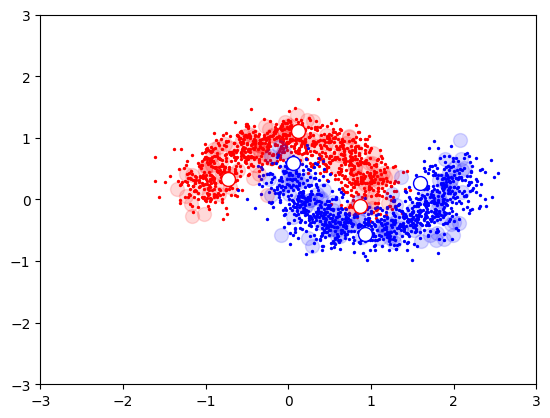

In [13]:
show_data()
plt.show()

### Neural Network

Meta Pseudo Paper
```
Training details. Our model architecture is a feed-forward
fully-connected neural network with two hidden layers, each
has 8 units. The sigmoid non-linearity is used at each layer.
In Meta Pseudo Labels, both the teacher and the student
share this architecture but have independent weights. All
networks are trained with SGD using a constant learning
rate of 0.1. The networks’ weights are initialized with the
uniform distribution between -0.1 and 0.1. We do not apply
any regularization.
```


Self Meta Pseudo Paper
```
Training details: We remove all data augmentations and
regularization losses. We use a simple neural network model
with two fully connected hidden layers. Each layer has 8 units.
We use a ReLU activation function [22], and train the model
with an initial learning rate of 0.1 for 1,000 steps. We use
the last checkpoint as the final checkpoint and evaluate it on
the whole dataset. For the supervised learning experiment, We
keep the hyperparameters unchanged but we train the model
with the labeled examples only.

```

## Experiment 1 : Ground Truth - Without considering unlabelled data. To calculate the upperbound.

In [14]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.fc1 = nn.Linear(in_features= 2, out_features= 8, bias= True)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(in_features= 8, out_features= 8, bias= True)
    self.relu2 = nn.ReLU()
    self.out = nn.Linear(in_features= 8, out_features= 1, bias= True)     #Binary classification , single node

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    out = self.out(x).reshape(-1)
    return out

In [15]:
model = Network().cuda()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
l_x = torch.tensor(x_train, dtype=torch.float32).cuda()
l_y = torch.tensor(y_train, dtype=torch.float32).cuda()

Step : [100/1000], Loss : 0.5956056714057922
Step : [200/1000], Loss : 0.5023364424705505
Step : [300/1000], Loss : 0.45278048515319824
Step : [400/1000], Loss : 0.34744203090667725
Step : [500/1000], Loss : 0.36808425188064575
Step : [600/1000], Loss : 0.29240092635154724
Step : [700/1000], Loss : 0.23607510328292847
Step : [800/1000], Loss : 0.1486981064081192
Step : [900/1000], Loss : 0.12459559738636017
Step : [1000/1000], Loss : 0.10210340470075607

upper bound
valid BCE loss: 0.14478741586208344
valid accuracy: 0.945


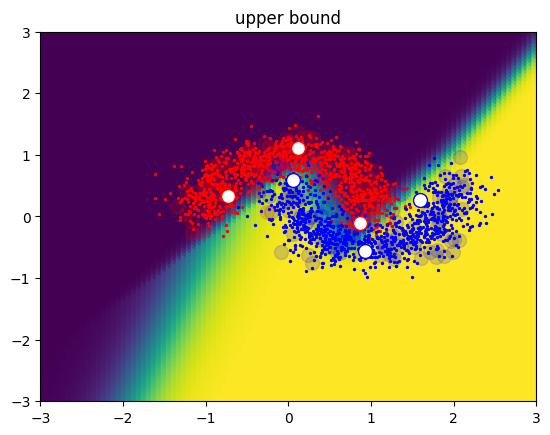

In [16]:
num_steps = 1000
for step in range(num_steps):
  # Forward pass
  # randomly sampling batches of 16 from data
  random_sample = np.random.choice(num_unlabel_perclass*2,16).tolist()
  u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()
  u_y = torch.from_numpy(y_unlabel[random_sample]).float().cuda()
  l_logit = model(l_x)
  u_logit = model(u_x)

  # Calculate the loss
  loss = (F.binary_cross_entropy_with_logits(l_logit,l_y)+ F.binary_cross_entropy_with_logits(u_logit,u_y))/2
  # Backprogation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Printing every 100 steps
  if (step + 1) %100 == 0:
    print(f'Step : [{step+1}/{num_steps}], Loss : {loss.item()}')


print('')
print('upper bound')
print_validate(model)
show_predict_space(model)
plt.title('upper bound')
plt.show()

# Experiment 2 : By training only on labelled data and inference on the unlabelled data


In [17]:
model = Network().cuda()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
l_x = torch.tensor(x_train, dtype=torch.float32).cuda()
l_y = torch.tensor(y_train, dtype=torch.float32).cuda()

Step : [100/100], Loss : 0.5963265895843506

labelled only
valid BCE loss: 0.5185446739196777
valid accuracy: 0.805


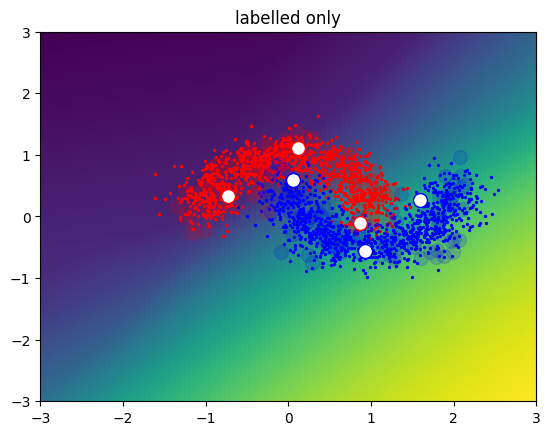

In [18]:
num_steps = 100
for step in range(num_steps):
  # Forward pass
  l_logit = model(l_x)

  # Calculate the loss
  loss = F.binary_cross_entropy_with_logits(l_logit,l_y)

  # Backprogation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Printing every 100 steps
  if (step + 1) %100 == 0:
    print(f'Step : [{step+1}/{num_steps}], Loss : {loss.item()}')


print('')
print('labelled only')
print_validate(model)
show_predict_space(model)
plt.title('labelled only')
plt.show()

# Experiment 3 - Meta Pseudo Label

This implemetation is based on the Metal Pseudo label paper

In [19]:
l_x = torch.from_numpy(x_train).float().cuda()
l_y = torch.from_numpy(y_train).float().cuda()

teacher = Network().cuda()
student = Network().cuda()
t_optimizer = optim.SGD(teacher.parameters(),lr=0.1)
s_optimizer = optim.SGD(student.parameters(),lr=0.1)

metal pseudo label : student
valid BCE loss: 0.7854405045509338
valid accuracy: 0.66


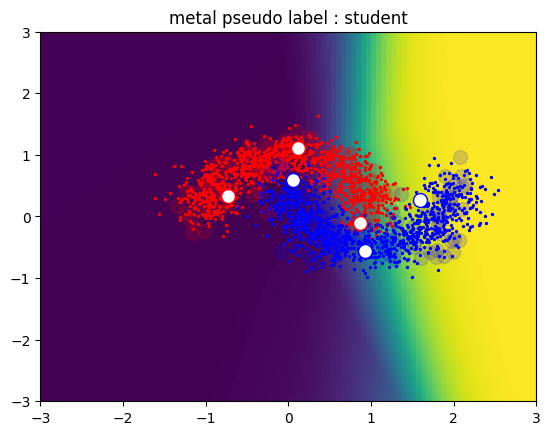

metal pseudo label : teacher
valid BCE loss: 0.4909253716468811
valid accuracy: 0.71


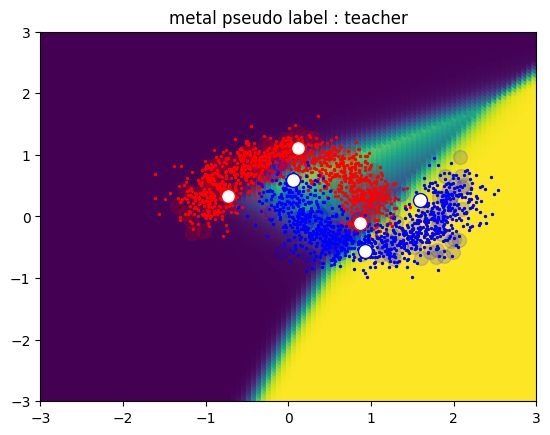

In [20]:
num_steps = 1000
for iteration in range(num_steps):
      # subscript: t,s : teacher,student
      # subscript: l,u : label,unlabel

    # Setting the models in train mode
    teacher.train()
    student.train()

    t_optimizer.zero_grad()
    s_optimizer.zero_grad()

    # randomly sampling batches of 16 from unlabelled data
    random_sample = np.random.choice(num_unlabel_perclass*2,16).tolist()
    u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()


    #prepare other input
    #note these is detached, i.e. not used for backprop
    s_l_logit = student(l_x)
    s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)

    t_u_logit = teacher(u_x)
    pseudo_y =  (t_u_logit.detach()>0).float()
    #------



    #train student : update student using pseudo label data only
    s_u_logit = student(u_x)
    s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y)
    s_u_loss.backward()
    s_optimizer.step()


    #train teacher : update teacher using pseudo label data student change in loss
    s_l_logit_new = student(l_x)
    s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new.detach(), l_y)
    #change = s_l_loss - s_l_loss_new #s_l_loss_new - s_l_loss ??
    change =  s_l_loss - s_l_loss_new
    #https://github.com/kekmodel/MPL-pytorch/issues/6

    t_l_logit = teacher(l_x)
    t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
    t_mpl_loss  = change * F.binary_cross_entropy_with_logits(t_u_logit, pseudo_y)

    (t_l_loss+t_mpl_loss).backward()
    t_optimizer.step()

    #print(iteration, s_u_loss.item(), t_l_loss.item(), t_mpl_loss.item())
#-------------------------------
print('metal pseudo label : student')
print_validate(student)
show_predict_space(student)
plt.title('metal pseudo label : student')
plt.show()

print('metal pseudo label : teacher')
print_validate(teacher)
show_predict_space(teacher)
plt.title('metal pseudo label : teacher')
plt.show()

# Self Meta Pseudo Label

Based on the Algorithm provided in the paper.
```
Algorithm 1: The Self Meta Pseudo Labels method
Input: Labeled data xl , yl and unlabeled data xu .
1 Initialize θM .
2 for k = 0 to N − 1 do
3 Sample a batch of unlabeled examples (xu ,xua )
and a batch of labeled examples (xl , yl )
4 Compute the hard pseudo labels H(pu ).
5 Compute the loss L1 (θM ) and gradient with the
pseudo labels.
6 Update the model: θM = θM − η1 · ∇L1 (θM )
7 Compute the new loss L2 (θM ) and gradient with
the pseudo labels and (xl , yl ).
8 Update the model: θM = θM − η2 · ∇L2 (θM )
9 end
10 return θM
```

In [76]:
model = Network().cuda()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
l_x = torch.tensor(x_train, dtype=torch.float32).cuda()
l_y = torch.tensor(y_train, dtype=torch.float32).cuda()


Self Meta Pseudo
valid BCE loss: 0.6587409973144531
valid accuracy: 0.905


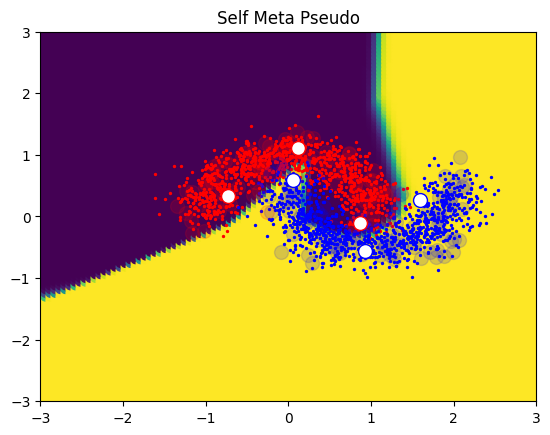

In [82]:
num_steps = 500

for step in range(num_steps):

  model.train()   # setting the model to train mode.
  optimizer.zero_grad()

  # randomly sampling batches of 16 from unlabelled data
  random_sample = np.random.choice(num_unlabel_perclass*2,16).tolist()
  u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()

  # predict on unlabelled data
  u_logit = model(u_x)
  # Do a Hard Pseudo Label prediction
  pseudo_y =  (u_logit>0).float()  # Hard Pseudo Label

  # Calculate the loss
  loss1 = F.binary_cross_entropy_with_logits(u_logit,pseudo_y)

  # Old loss on labeled images
  old_l_logit = model(l_x)
  old_loss = F.binary_cross_entropy_with_logits(old_l_logit,l_y)

  # Backprop on Loss 1
  loss1.backward()
  optimizer.step()

  # New loss on labeled images
  new_l_logit = model(l_x)
  new_loss = F.binary_cross_entropy_with_logits(new_l_logit,l_y)

  # Find the loss by the model after it is updated
  u_logit_new = model(u_x)
  pseudo_y_new = (u_logit_new>0).float()

  loss_uda = new_loss

  # Calculate the change in the loss
  change = old_loss - new_loss

  # Caluclate the loss_mpl
  loss_mpl = change * F.binary_cross_entropy_with_logits(u_logit_new,pseudo_y_new)

  # Assuming lambda to be 1 L2 = L_uda + (lamda)L_mpl
  (loss_mpl.detach() + loss_uda ).backward()
  optimizer.step()



print('')
print('Self Meta Pseudo')
print_validate(model)
show_predict_space(model)
plt.title('Self Meta Pseudo')
plt.show()

## Considering the accuracy on the validation dataset , Self Meta is the closest to the upper bound

### Trail by considering a 5,1 distrubution as in the paper

In [ ]:
num_unlabel_perclass =  997        #(2000-6)/2
# num_train_perclass = 3             # 6/2
num_valid_perclass = 100

In [ ]:
x_unlabel,y_unlabel = datasets.make_moons(n_samples=num_unlabel_perclass*2, shuffle=False, noise=0.2, random_state=56)
x_train, y_train = datasets.make_moons(n_samples=(5,1), shuffle=False, noise=0.2, random_state=33)
x_valid, y_valid = datasets.make_moons(n_samples=num_valid_perclass*2, shuffle=False, noise=0.2, random_state=98)

In [ ]:
print(x_unlabel.max(),x_unlabel.min())

2.565992030962115 -1.4398273569076028


In [ ]:
grid = torch.meshgrid(torch.linspace(-3, 3, steps=100), torch.linspace(-3, 3, steps=100))#, indexing='ij')
grid = torch.stack(grid,-1)
grid = grid.reshape(-1,2).cuda()

In [ ]:
def show_data():
    plt.scatter(x_unlabel[:num_unlabel_perclass,0],x_unlabel[:num_unlabel_perclass,1], s=2, alpha=1, facecolors='r',)
    plt.scatter(x_unlabel[num_unlabel_perclass:,0],x_unlabel[num_unlabel_perclass:,1], s=2, alpha=1, facecolors='b',)
    plt.scatter(x_valid[:num_valid_perclass,0],x_valid[:num_valid_perclass,1], s=100, alpha=0.15, c='r',)
    plt.scatter(x_valid[num_valid_perclass:,0],x_valid[num_valid_perclass:,1], s=100, alpha=0.15, c='b',)
    plt.scatter(x_train[:5,0],x_train[:5,1], s=100, alpha=1, edgecolors='b', facecolors='w',)
    plt.scatter(x_train[1:,0],x_train[1:,1], s=100, alpha=1, edgecolors='r', facecolors='w',)
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])

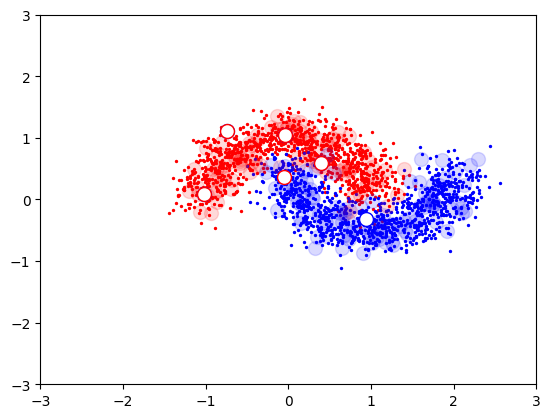

In [ ]:
show_data()
plt.show()

# Experiment  : By training only on labelled data and inference on the unlabelled data


In [ ]:
model = Network().cuda()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
l_x = torch.tensor(x_train, dtype=torch.float32).cuda()
l_y = torch.tensor(y_train, dtype=torch.float32).cuda()

Step : [100/1000], Loss : 0.4193824529647827
Step : [200/1000], Loss : 0.37813398241996765
Step : [300/1000], Loss : 0.29585692286491394
Step : [400/1000], Loss : 0.1783979833126068
Step : [500/1000], Loss : 0.0817466527223587
Step : [600/1000], Loss : 0.038951724767684937
Step : [700/1000], Loss : 0.02166348695755005
Step : [800/1000], Loss : 0.01384968962520361
Step : [900/1000], Loss : 0.009758161380887032
Step : [1000/1000], Loss : 0.007300287019461393

labelled only
valid BCE loss: 4.67702054977417
valid accuracy: 0.59


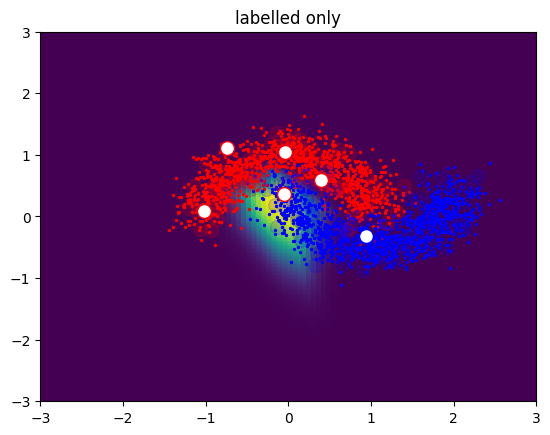

In [ ]:
num_steps = 1000
for step in range(num_steps):
  # Forward pass
  l_logit = model(l_x)

  # Calculate the loss
  loss = F.binary_cross_entropy_with_logits(l_logit,l_y)

  # Backprogation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Printing every 100 steps
  if (step + 1) %100 == 0:
    print(f'Step : [{step+1}/{num_steps}], Loss : {loss.item()}')


print('')
print('labelled only')
print_validate(model)
show_predict_space(model)
plt.title('labelled only')
plt.show()

# Experiment - Meta Pseudo Label

This implemetation is by reference

In [ ]:
l_x = torch.from_numpy(x_train).float().cuda()
l_y = torch.from_numpy(y_train).float().cuda()

teacher = Network().cuda()
student = Network().cuda()
t_optimizer = optim.SGD(teacher.parameters(),lr=0.1)
s_optimizer = optim.SGD(student.parameters(),lr=0.1)

metal pseudo label : student
valid BCE loss: 2.746565580368042
valid accuracy: 0.605


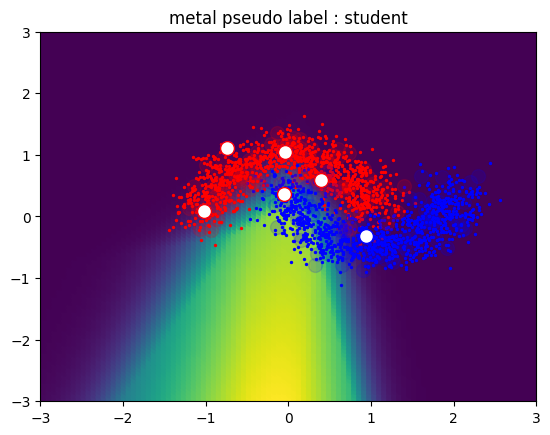

metal pseudo label : teacher
valid BCE loss: 5.426036357879639
valid accuracy: 0.63


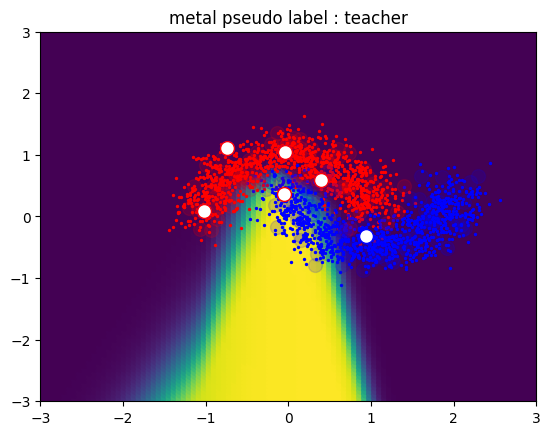

In [ ]:
num_steps = 1000
for iteration in range(num_steps):
      # subscript: t,s : teacher,student
      # subscript: l,u : label,unlabel

    # Setting the models in train mode
    teacher.train()
    student.train()

    t_optimizer.zero_grad()
    s_optimizer.zero_grad()

    # randomly sampling batches of 16 from unlabelled data
    random_sample = np.random.choice(num_unlabel_perclass*2,16).tolist()
    u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()


    #prepare other input
    #note these is detached, i.e. not used for backprop
    s_l_logit = student(l_x)
    s_l_loss = F.binary_cross_entropy_with_logits(s_l_logit.detach(), l_y)

    t_u_logit = teacher(u_x)
    pseudo_y =  (t_u_logit.detach()>0).float()
    #------



    #train student : update student using pseudo label data only
    s_u_logit = student(u_x)
    s_u_loss  = F.binary_cross_entropy_with_logits(s_u_logit, pseudo_y)
    s_u_loss.backward()
    s_optimizer.step()


    #train teacher : update teacher using pseudo label data student change in loss
    s_l_logit_new = student(l_x)
    s_l_loss_new  = F.binary_cross_entropy_with_logits(s_l_logit_new.detach(), l_y)
    #change = s_l_loss - s_l_loss_new #s_l_loss_new - s_l_loss ??
    change = s_l_loss_new - s_l_loss
    #https://github.com/kekmodel/MPL-pytorch/issues/6

    t_l_logit = teacher(l_x)
    t_l_loss = F.binary_cross_entropy_with_logits(t_l_logit, l_y)
    t_mpl_loss  = change * F.binary_cross_entropy_with_logits(t_u_logit, pseudo_y)

    (t_l_loss+t_mpl_loss).backward()
    t_optimizer.step()

    #print(iteration, s_u_loss.item(), t_l_loss.item(), t_mpl_loss.item())
#-------------------------------
print('metal pseudo label : student')
print_validate(student)
show_predict_space(student)
plt.title('metal pseudo label : student')
plt.show()

print('metal pseudo label : teacher')
print_validate(teacher)
show_predict_space(teacher)
plt.title('metal pseudo label : teacher')
plt.show()

# Self Meta Pseudo Label

Based on the Algorithm provided in the paper.
```
Algorithm 1: The Self Meta Pseudo Labels method
Input: Labeled data xl , yl and unlabeled data xu .
1 Initialize θM .
2 for k = 0 to N − 1 do
3 Sample a batch of unlabeled examples (xu ,xua )
and a batch of labeled examples (xl , yl )
4 Compute the hard pseudo labels H(pu ).
5 Compute the loss L1 (θM ) and gradient with the
pseudo labels.
6 Update the model: θM = θM − η1 · ∇L1 (θM )
7 Compute the new loss L2 (θM ) and gradient with
the pseudo labels and (xl , yl ).
8 Update the model: θM = θM − η2 · ∇L2 (θM )
9 end
10 return θM
```

In [ ]:
model3 = Network().cuda()
optimizer = optim.SGD(model3.parameters(), lr = 0.1)
l_x = torch.tensor(x_train, dtype=torch.float32).cuda()
l_y = torch.tensor(y_train, dtype=torch.float32).cuda()


Self Meta Pseudo
valid BCE loss: 0.6999812126159668
valid accuracy: 0.805


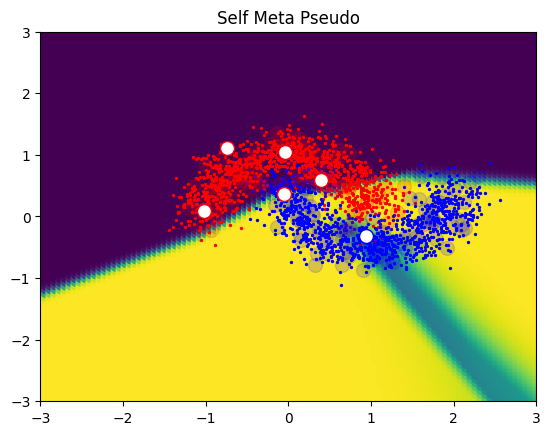

In [ ]:
num_steps = 1000
for step in range(num_steps):

  model.train()   # setting the model to train mode.

  # randomly sampling batches of 16 from unlabelled data
  random_sample = np.random.choice(num_unlabel_perclass*2,16).tolist()
  u_x = torch.from_numpy(x_unlabel[random_sample]).float().cuda()

  # predict on unlabelled data
  u_logit = model3(u_x)
  # Do a Hard Pseudo Label prediction
  pseudo_y =  (u_logit>0).float()  # Hard Pseudo Label

  # Calculate the loss
  loss1 = F.binary_cross_entropy_with_logits(u_logit,pseudo_y)

  # Backprop on Loss 1
  optimizer.zero_grad()
  loss1.backward()
  optimizer.step()

  l_logit = model3(l_x)
  loss_uda = F.binary_cross_entropy_with_logits(l_logit,l_y)

  # Find the loss by the model after it is updated
  u_logit_new = model3(u_x)
  pseudo_y_new = (u_logit_new>0).float()
  loss_new = F.binary_cross_entropy_with_logits(u_logit_new,pseudo_y_new)

  # Calculate the change in the loss
  change = loss_new - loss1.detach()

  # Caluclate the loss_mpl
  loss_mpl = change * loss_new

  # Assuming lambda to be 1 L2 = L_uda + (lamda)L_mpl
  (loss_mpl + loss_uda ).backward()
  optimizer.step()



print('')
print('Self Meta Pseudo')
print_validate(model3)
show_predict_space(model3)
plt.title('Self Meta Pseudo')
plt.show()